## Scenario Descriptions

### CAGE Challenge 2

Your firm has been contracted by Florin to trial your new autonomous defence agents. Florin have given your agent authority to defend the computer network at one of their manufacturing plants. The network, shown in Figure 1, contains a user network for staff, an enterprise network, and an operational network which contains the key manufacturing and logistics servers. The defence agent receives an alert feed from Florin’s existing monitoring systems. It can run detailed analyses on hosts, then remove malicious software if found. If an attacker is too well established on a host to be removed, the host can be restored from a clean backup. Finally, the defence agent can deceive attackers by creating decoy services.

The network owner has undertaken an evaluation of the factory systems and contracted your firm to defend these systems according to the following criteria:

Maintain the critical operational server to ensure information about the new weapon system is not revealed to Guilder and the production and delivery of the new weapon system remains on schedule.
Where possible, maintain enterprise servers to ensure day-to-day operations of the manufacturing plant are not disrupted or revealed.”

Subnet 1 consists of user hosts that are not critical. \
Subnet 2 consists of enterprise servers designed to support the user activities on Subnet 1. \
Subnet 3 contains the critical operational server and three user hosts.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure1.png">

The effect of each action on the state of a targeted host is summarized with the diagram.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure2.png" caption="State Diagram">

### Appendix - Action Sets

Blue Action Sets
    
| Action     | Purpose                                                                                                                                                                                                                                                 | Parameters                                                                    | Output                                 |
|:-----------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------|:---------------------------------------|
| Monitor | Collection of information about flagged malicious activity on the system\. Corresponds to action ID 1: Scan in the OpenC2 specification[^3]\.                                                                                                           | None *\(Note: This action occurs automatically if another action is chosen\)* | Network connections and associated processes that are identified as malicious\. |
| Analyse | Collection of further information on a specific host to enable blue to better identify if red is present on the system\. Corresponds to action ID 30: Investigate in the OpenC2 specification\.                                                         | Hostname                                                                      | Information on files associated with recent alerts including signature and entropy\.  |
| DecoyApache, DecoyFemitter, DecoyHarakaSMPT, DecoySmss, DecoySSHD, DecoySvchost, DecoyTomcat | Setup of a decoy service (as specified by the action name) on a specified host\. Green agents do not access these services, so any access is a clear example of red activity\.                                                                                                            | Hostname                                                                | An alert if the red agent accesses the new service\. |
| Remove | Attempting to remove red from a host by destroying malicious processes, files and services\. This action attempts to stop all processes identified as malicious by the monitor action\. Corresponds to action ID 10: Stop in the OpenC2 specification\. | Hostname                                                                      | Success/Failure |
| Restore | Restoring a system to a known good state\. This has significant consequences for system availability\. This action punishes Blue by \-1\. Corresponds to action ID 23: Restore in the OpenC2 specification\.                                            | Hostname                                                                      | Success/Failure  |

Red Action Sets

| Action     | Purpose                                                                                                                                                    | Parameters       | Output                                 |
|:-----------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------|:---------------------------------------|
| Discover Remote Systems | ATT&CK[^4] Technique T1018 Remote System Discovery\. Discovers new hosts/IP addresses in the network through active scanning using tools such as ping\.    | Subnet           | IP addresses in the chosen subnet from hosts that respond to ping |
| Discover Network Services | ATT&CK Technique T1046 Network Service Scanning. Discovers responsive services on a selected host by initiating a connection with that host\.              | Subnet           | Ports and service information |
| Exploit Network Services | ATT&CK Technique T1210 Exploitation of Remote Services\. This action attempts to exploit a specified service on a remote system\.                          | IP Address, Port | Success/Failure <br /> Initial recon of host if successful. |
| Escalate | ATT&CK Tactic TA0004 Privilege Escalation\. This action escalates the agent’s privilege on the host\.                                                      | Hostname         | Success/Failure <p> Internal information now available due to increased access to the host |
| Impact | ATT&CK Technique T1489 Service Stop\. This action disrupts the performance of the network and fulfils red’s objective of denying the operational service\. | Hostname         | Success/Failure  |

[^3]: Open Command and Control \(OpenC2\), [https://openc2\.org/](https://openc2\.org/)

[^4]: MITRE ATT&CK, [https://attack\.mitre\.org/](https://attack\.mitre\.org/)

### Agents

- Rules-based agents
- Deep Reinforcement Learning agents

### Rule-based agents

- Blue
    - RandomAgent: Takes a random action or a test action based on the epsilon value
    - BlueReactRemoveAgent: Adds suspicious hosts to the host list if the monitor finds something and then it will remove the program(session)
    - BlueReactRestoreAgent: Similar steps but restore the host from a cleaned backup.
- Red
    - RedMeanderAgent: Explores the network one subnet at a time, seeking to gain privileged access to all hosts in a subnet before moving on to the next one, eventually arriving at the Operational Server.
    - B_lineAgent: Attempts to move straight to the Operational Server using prior knowledge of the network layout.

In [1]:
from CybORG import CybORG
import inspect
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gravis as gv
from networkx import connected_components

from CybORG.Agents import B_lineAgent, BlueReactRestoreAgent, BlueReactRemoveAgent, \
    RandomAgent, RedMeanderAgent
from CybORG.Agents.Wrappers import EnumActionWrapper
from CybORG.Agents.Wrappers.FixedFlatWrapper import FixedFlatWrapper
from CybORG.Agents.Wrappers.IntListToAction import IntListToActionWrapper
from CybORG.Agents.Wrappers.OpenAIGymWrapper import OpenAIGymWrapper
from CybORG.Simulator.Scenarios.FileReaderScenarioGenerator import FileReaderScenarioGenerator

/home/ubuntu/.local/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


path is: /home/ubuntu/CybORG/CybORG/env.py


## Visualization

- input 
    - Observation from Red and Blue
    - Action for Blue / Red?
    - link_diagram

In [5]:
def run_episode_cc2(cyborg, agent):
    cyborg.reset()
    ip_map = cyborg.environment_controller.state.ip_addresses
    host_map = { host:str(ip) for ip, host in ip_map.items()}
    a = ''
    node_shapes = {
        'host': 'o',    # Circle
        'router': '^',  # Triangle
        'server': 's'   # Square
    }
    for i in range(25):
        # Blue
        blue_action_space = cyborg.get_action_space('Blue')
        blue_obs = cyborg.get_observation('Blue') # get the newest observation
        blue_action = agent.get_action(blue_obs, blue_action_space)
        print(f"===Perform the {i+1} step at CybORG level===")
        
        # take a step
        results = cyborg.step('Blue', blue_action, skip_valid_action_check=False)

        pprint(f"Action for Blue is {blue_action}")
        pprint(f"Observation for Blue is {cyborg.get_observation('Blue')}")
        print("=====")
        # print(f"Observation for Green is {cyborg.get_observation('Green')}")
        pprint(f"Action for Red is {cyborg.get_last_action('Red')}")
        pprint(f"Observation for Red is {cyborg.get_observation('Red')}")
        print("=====")
        
        pprint(host_map)
        
        # calculate host status with a helper function given observation from Blue and Red
        # status = generate_new_status(status, )
        
        print('--> link diagram:')
        link_diagram = cyborg.environment_controller.state.link_diagram
        ################
        ## Color Map  ##
        ################
        # print("Nodes:")
        # pprint(link_diagram.nodes)
        # pprint(node_shapes)
        # print("Edges:")
        # pprint(link_diagram.edges)
        # for node1, node2 in link_diagram.edges:
        #     print((node1, node2))

        red_action_str = cyborg.get_last_action('Red').__str__()
        blue_action_str = cyborg.get_last_action('Blue').__str__()
        target_host = None
        reset_host = None
        if 'Exploit' in red_action_str or 'Privilege' in red_action_str:
            pprint(cyborg.get_observation('Red')['success'].__str__())
            if cyborg.get_observation('Red')['success'].__str__() == 'TRUE':
                target_host = red_action_str.split(" ")[-1]
        if 'Remove' in blue_action_str:
            if cyborg.get_observation('Blue')['success'].__str__() == 'TRUE':
                reset_host = blue_action_str.split(" ")[-1]
                
        pos = nx.spring_layout(link_diagram, seed=3113794652)  # positions for all nodes
        for node in link_diagram.nodes:
            # if 'router' in node:
            #     continue
            type = ""
            if 'Server' in node:
                type = 'server'
            elif 'router' in node:
                type = 'router'
            else:
                type = 'host'
                
            if target_host and (node == target_host or node == ip_map[target_host]):
                nx.set_node_attributes(link_diagram, {node:{'compromised':True, 'name':node, 'type':node_shapes[type]}})
            else:
                ### if previous node is compromised
                ### check if the blue has do something with it
                if target_host != reset_host:
                    continue
                nx.set_node_attributes(link_diagram, {node:{'compromised':False, 'name':node, 'type':node_shapes[type]}})
            
            # print(link_diagram.nodes[node])
            
        shapes = nx.get_node_attributes(link_diagram, 'type')
        node_colors = ["red" if link_diagram.nodes[node].get('compromised', True) else "green" for node in link_diagram.nodes]
        node_labels = [node for node in link_diagram.nodes]
        # nx.draw_networkx_nodes(link_diagram, pos, nodelist=link_diagram.nodes, node_color=node_colors)
        # nx.draw_networkx_labels(link_diagram, pos, labels=link_diagram.nodes, font_family='sans-serif', font_weight='bold')
        
        # nx.draw_networkx(link_diagram, pos, node_color=node_colors, labels=link_diagram.nodes,with_labels=True, font_weight='bold')
        nx.draw_networkx(link_diagram, pos, node_color=node_colors, with_labels=True, font_weight='bold')

        agent_actions = {
            "Red": {"action": red_action_str, "success": cyborg.get_observation('Red')['success'].__str__()},
            "Blue": {"action": blue_action_str, "success": cyborg.get_observation('Blue')['success'].__str__()}
        }

        # Increase this value to add more space between rows
        vertical_padding = 0.1

        # Display Agent Action Information
        for idx, (agt, action_info) in enumerate(agent_actions.items()):
            plt.text(1.05, 1 - vertical_padding * idx, f"{agt}: {action_info['action']} - {action_info['success']}",
                     transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

        ip_map_start_pos = 1 - len(agent_actions) * vertical_padding - 0.1

        # Display IP Address Mapping to the right of the plot
        for idx, (ip, host) in enumerate(ip_map.items()):
            plt.text(1.05, ip_map_start_pos - idx * vertical_padding, f"{ip}: {host}",
                     transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5))

        plt.title(f'Step {i+1}: Network State')
        plt.show()

        print("====")
        # print('--> state object:')
        # pprint(cyborg.environment_controller.state.__str__())
        
    

Mouse over event oberservations 
Different Shape
Different State

In [3]:
# input('start? ')
# CC2
path = str(inspect.getfile(CybORG))
# path = path[:-7] + f'/Simulator/Scenarios/scenario_files/ScenarioDemo.yaml'
# path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario_5nodes_randomgame.yaml'
path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
sg = FileReaderScenarioGenerator(path)
red_agent = RedMeanderAgent()
cyborg = CybORG(sg, 'sim', agents={'Red': red_agent})

env is: sim


/home/ubuntu/.local/lib/python3.10/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
===Perform the 1 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverRemoteSystems 10.0.208.240/28}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: D

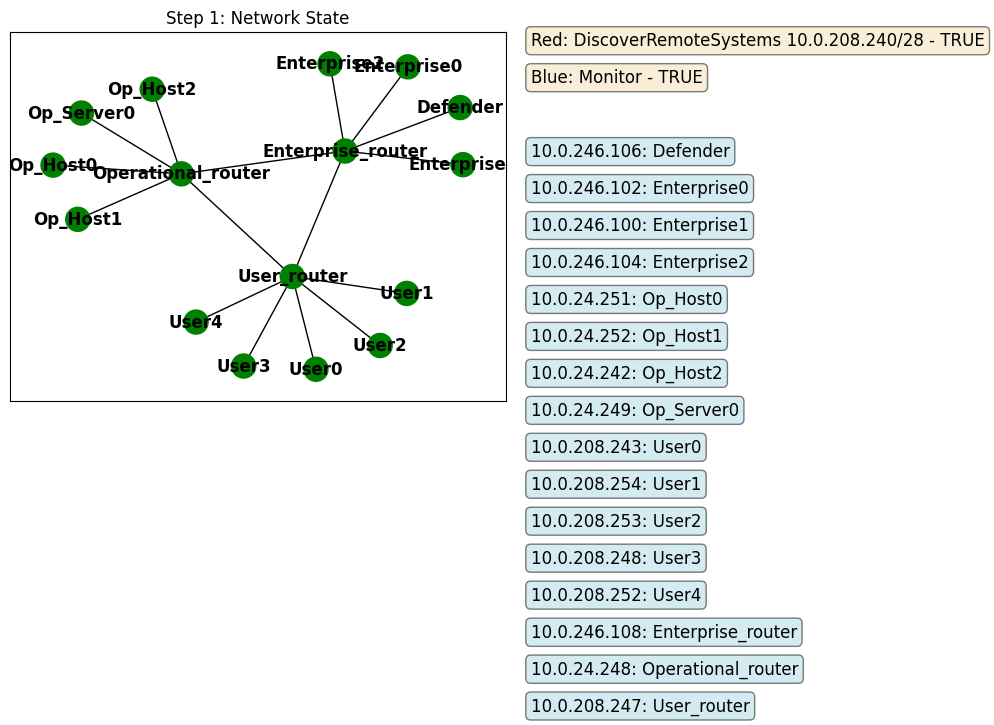

====
===Perform the 2 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverNetworkServices 10.0.208.254}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: DiscoverNetworkServices 10.0.208.254 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.DiscoverNetworkServices.DiscoverNetworkServices'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulato

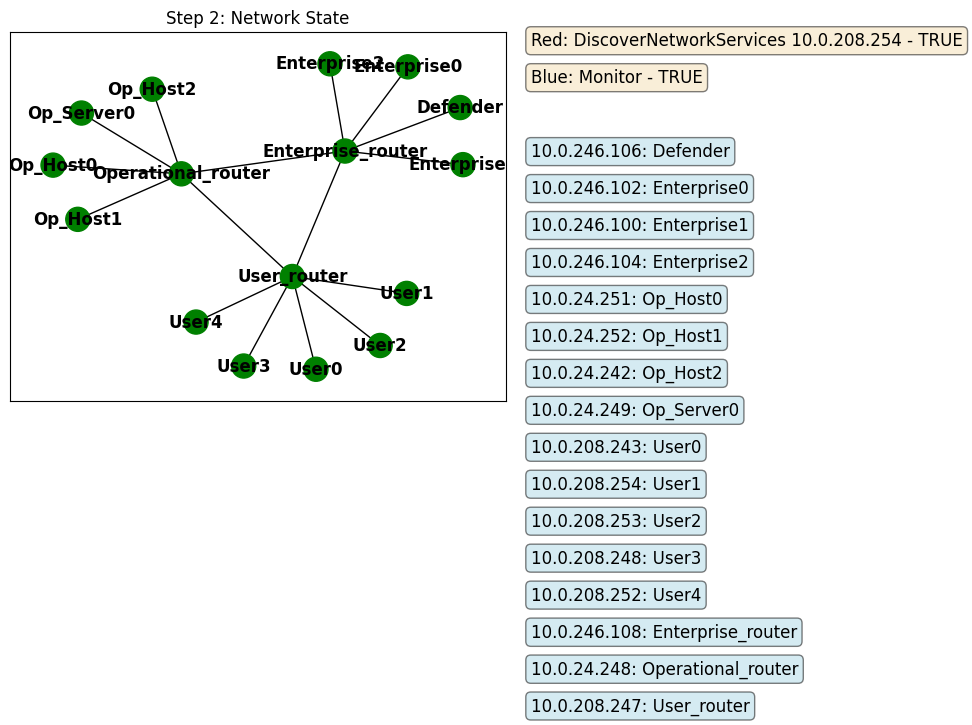

====
===Perform the 3 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverNetworkServices 10.0.208.243}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: DiscoverNetworkServices 10.0.208.243 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.DiscoverNetworkServices.DiscoverNetworkServices'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulato

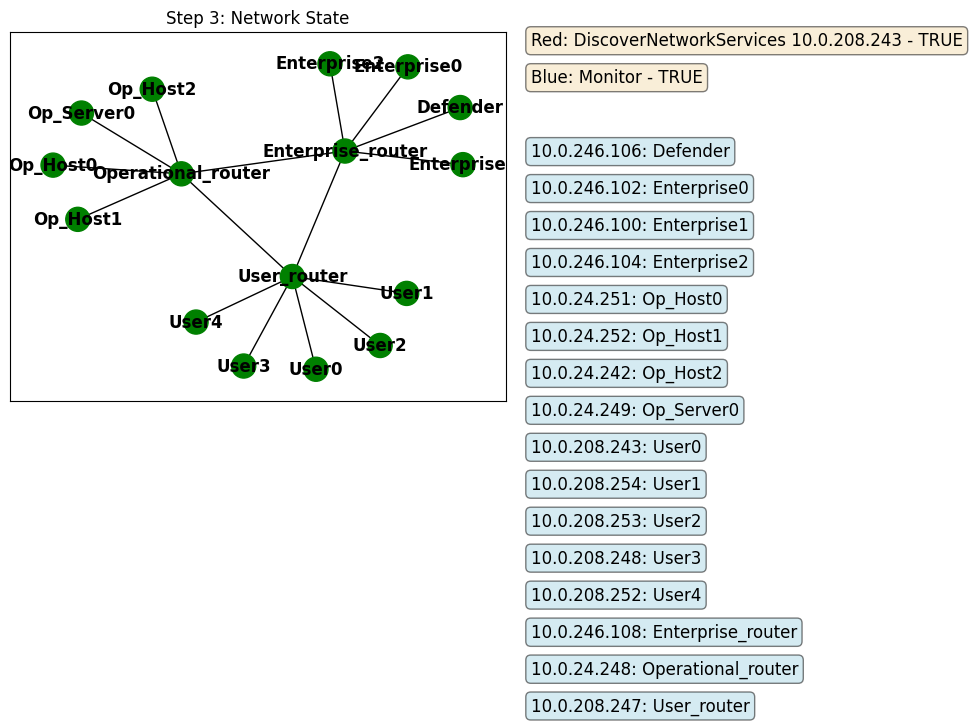

====
===Perform the 4 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverNetworkServices 10.0.208.253}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: DiscoverNetworkServices 10.0.208.253 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.DiscoverNetworkServices.DiscoverNetworkServices'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulato

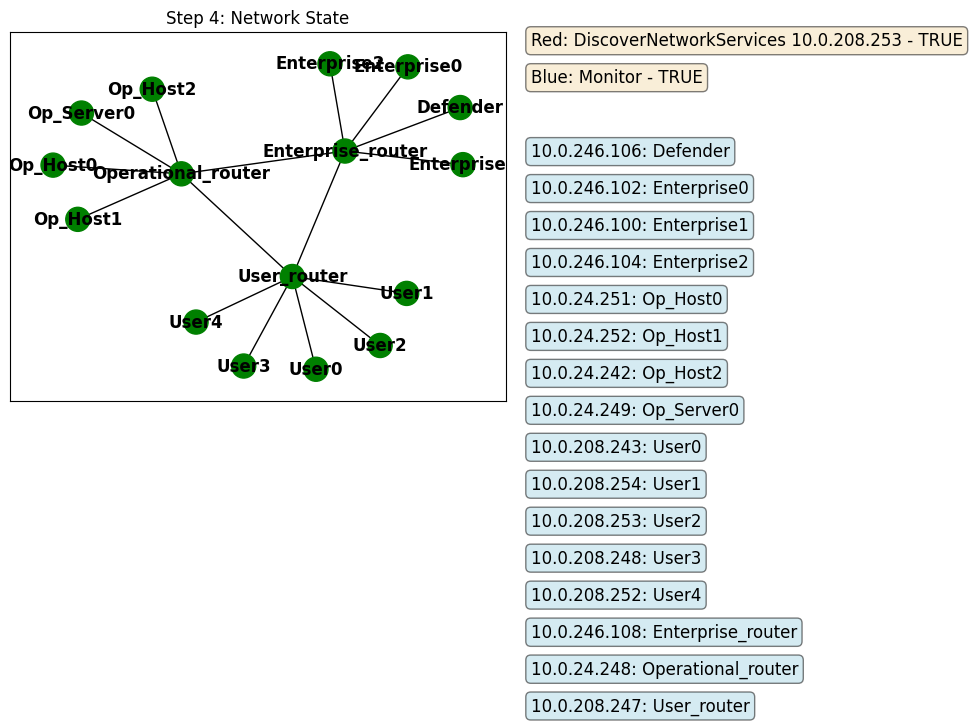

====
===Perform the 5 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverNetworkServices 10.0.208.252}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: DiscoverNetworkServices 10.0.208.252 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.DiscoverNetworkServices.DiscoverNetworkServices'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulato

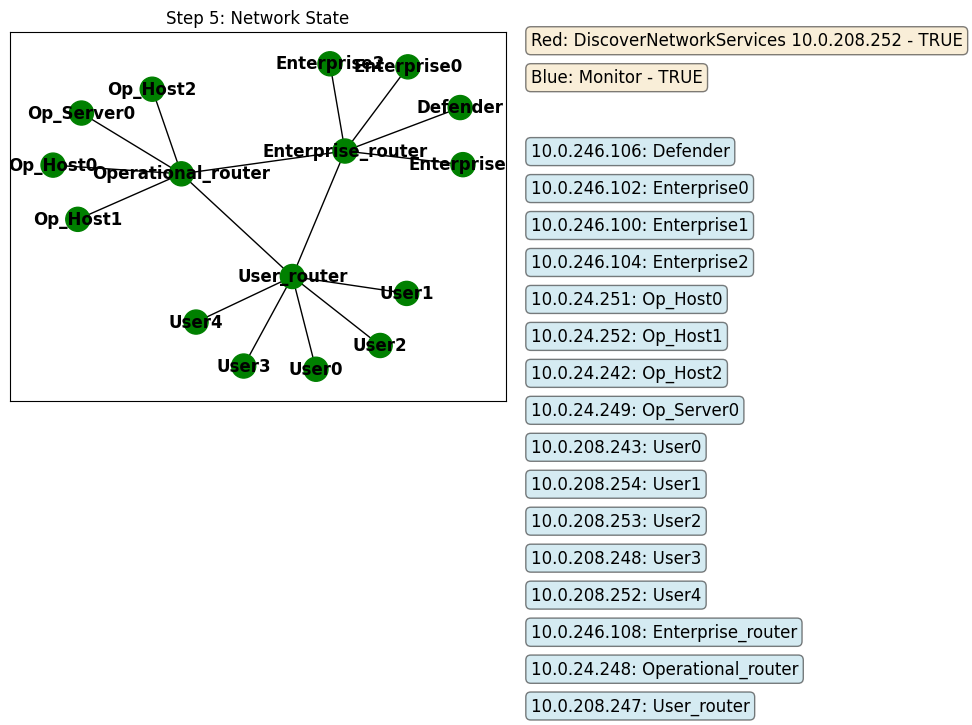

====
===Perform the 6 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': DiscoverNetworkServices 10.0.208.248}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: DiscoverNetworkServices 10.0.208.248 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.DiscoverNetworkServices.DiscoverNetworkServices'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulato

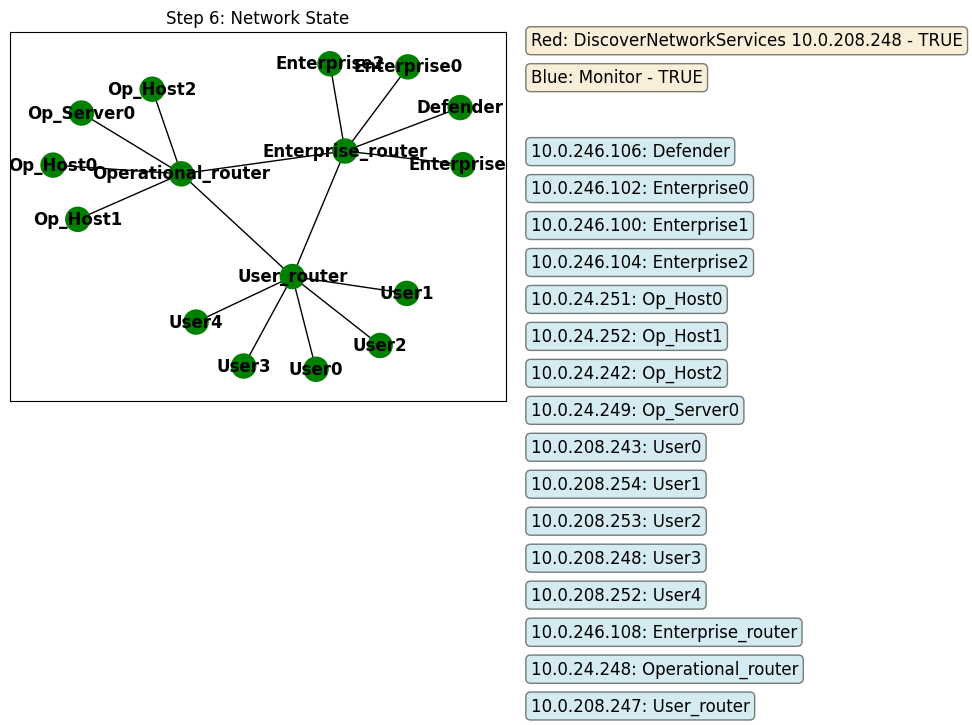

====
===Perform the 7 step at CybORG level===
====Perform a step====
The action to be performed is: {'Blue': Monitor}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0eb0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0ca0>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f1a824e0bb0>}
action is: {'Blue': Monitor, 'Green': Sleep, 'Red': PrivilegeEscalate User0}
--> in actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Monitor'>
--> in actions
In simcontroller execute action
action is: PrivilegeEscalate User0 its type is: <class 'CybORG.Simulator.Actions.AbstractActions.PrivilegeEscalate.PrivilegeEscalate'>
--> in end turn actions
In simcontroller execute action
action is: Monitor its type is: <class 'CybORG.Simulator.Actions.AbstractActions.Monitor.Moni

KeyError: 'User0'

In [6]:
# input('demo react remove')
agent = BlueReactRemoveAgent()
run_episode_cc2(cyborg, agent)

## Training

In [27]:
MAX_STEPS_PER_GAME = 20
MAX_EPS = 20

In [28]:
def run_training_example_rb(scenario):
    agent_name = 'Red'
    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/{scenario}.yaml'
    sg = FileReaderScenarioGenerator(path)
    cyborg = CybORG(scenario_generator=sg)
    cyborg = OpenAIGymWrapper(agent_name=agent_name,
                              env=FixedFlatWrapper(cyborg))

    observation = cyborg.reset()
    action_space = cyborg.action_space
    print(f"Observation size {len(observation)}, Action Size {action_space}")
    action_count = 0
    agent = RandomAgent()
    print(agent)
    agent.set_initial_values(action_space, observation)
    for i in range(MAX_EPS):  # laying multiple games
        print(f"\rTraining Game: {i}\n", end='', flush=True)
        reward = 0
        for j in range(MAX_STEPS_PER_GAME):  # step in 1 game
            action = agent.get_action(observation, action_space)
            print(f"Action is {action} for {agent}")
            next_observation, r, done, info = cyborg.step(action)

            action_space = cyborg.action_space
            reward += r

            agent.train(observation)  # training the agent
            observation = next_observation
            if done or j == MAX_STEPS_PER_GAME - 1:
                print(f"Training reward: {reward}")
                break
        agent.end_episode()
        observation = cyborg.reset()
        action_space = cyborg.action_space
        agent.set_initial_values(action_space, observation)

In [29]:
run_training_example_rb('Scenario2')

env is: sim
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff1430276a0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143025540>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143025390>}
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143482ef0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143482440>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143483c40>}
Observation size 11293, Action Size Discrete(212)
RandomAgent
Training Game: 0
Action is 125 for RandomAgent
====Perform a step====
The action to be performed is: {'Red': HTTPSRFI}
In SimulationController script
In shared EnvironmentController script
Agent interface: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143482ef0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7ff143482440>, 'Red': <CybORG.Shared.AgentInter

### Q-Learning Agent

In [30]:
def run_training_example_q_learning(scenario):
    agent_name = 'Red'
    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/{scenario}.yaml'
    sg = FileReaderScenarioGenerator(path)
    cyborg = CybORG(scenario_generator=sg)
    cyborg = OpenAIGymWrapper(agent_name=agent_name,
                              env=FixedFlatWrapper(cyborg))

    observation = cyborg.reset()
    action_space = cyborg.action_space
    print(f"Observation size {len(observation)}, Action Size {action_space}")
    action_count = 0
    agent = RandomAgent()
    print(agent)
    agent.set_initial_values(action_space, observation)
    for i in range(MAX_EPS):  # laying multiple games
        print(f"\rTraining Game: {i}\n", end='', flush=True)
        reward = 0
        for j in range(MAX_STEPS_PER_GAME):  # step in 1 game
            action = agent.get_action(observation, action_space)
            next_observation, r, done, info = cyborg.step(action)

            action_space = cyborg.action_space
            reward += r

            agent.train(observation)  # training the agent
            observation = next_observation
            if done or j == MAX_STEPS_PER_GAME - 1:
                print(f"Training reward: {reward}")
                break
        agent.end_episode()
        observation = cyborg.reset()
        action_space = cyborg.action_space
        agent.set_initial_values(action_space, observation)

### Deep RL Algorithms Agent

- PPO

In [31]:
#!pip install -U "ray[all]"

In [32]:
# import inspect
# import numpy as np
# from CybORG import CybORG
# from CybORG.Agents import B_lineAgent, GreenAgent
# from CybORG.Agents.Wrappers import ChallengeWrapper

In [33]:
# from ray import tune

# tune.run(
#     "PPO",
#     config={
#         "env": "YourEnvName",
#         "num_gpus": 0,
#         "other_config_options": "...",
#     }
# )

In [34]:
# from ray.rllib.algorithms.ppo import PPOConfig

# config = (  # 1. Configure the algorithm,
#     PPOConfig()
#     .environment("Taxi-v3")
#     .rollouts(num_rollout_workers=2)
#     .framework("torch")
#     .training(model={"fcnet_hiddens": [64, 64]})
#     .evaluation(evaluation_num_workers=1)
# )

# algo = config.build()  # 2. build the algorithm,

# for _ in range(5):
#     print(algo.train())  # 3. train it,

# algo.evaluate()  # 4. and evaluate it.

In [35]:
# from ray.rllib.algorithms import ppo
# from ray.rllib.env import ParallelPettingZooEnv
# from ray.tune import register_env

In [36]:
# from CybORG.Agents.Wrappers.PettingZooParallelWrapper import PettingZooParallelWrapper
# from CybORG.Simulator.Scenarios import FileReaderScenarioGenerator, DroneSwarmScenarioGenerator

In [37]:
class RLLibWrapper(ChallengeWrapper):
    def init(self, agent_name, env, reward_threshold=None, max_steps=None):
        super().__init__(agent_name, env, reward_threshold, max_steps)

    def step(self, action=None):
        obs, reward, done, info = self.env.step(action=action)
        self.step_counter += 1
        if self.max_steps is not None and self.step_counter >= self.max_steps:
            done = True
        return np.float32(obs), reward, done, info

    def reset(self):
        self.step_counter = 0
        obs = self.env.reset()
        return np.float32(obs)

NameError: name 'ChallengeWrapper' is not defined

In [ ]:
def env_creator_CC1(env_config: dict):
    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario1b.yaml'
    sg = FileReaderScenarioGenerator(path)
    agents = {"Red": B_lineAgent(), "Green": GreenAgent()}
    cyborg = CybORG(scenario_generator=sg, environment='sim', agents=agents)
    env = RLLibWrapper(env=cyborg, agent_name="Blue", max_steps=100)
    return env

In [ ]:
def env_creator_CC2(env_config: dict):
    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)
    agents = {"Red": B_lineAgent(), "Green": GreenAgent()}
    cyborg = CybORG(scenario_generator=sg, environment='sim', agents=agents)
    env = RLLibWrapper(env=cyborg, agent_name="Blue", max_steps=100)
    return env

In [ ]:
def env_creator_CC3(env_config: dict):
    sg = DroneSwarmScenarioGenerator()
    cyborg = CybORG(scenario_generator=sg, environment='sim')
    env = ParallelPettingZooEnv(PettingZooParallelWrapper(env=cyborg))
    return env

In [ ]:
def print_results(results_dict):
    train_iter = results_dict["training_iteration"]
    r_mean = results_dict["episode_reward_mean"]
    r_max = results_dict["episode_reward_max"]
    r_min = results_dict["episode_reward_min"]
    print(f"{train_iter:4d} \tr_mean: {r_mean:.1f} \tr_max: {r_max:.1f} \tr_min: {r_min: .1f}")

In [ ]:
# if __name__ == "__main__":
#     register_env(name="CC1", env_creator=env_creator_CC1)
#     register_env(name="CC2", env_creator=env_creator_CC2)
#     register_env(name="CC3", env_creator=env_creator_CC3)
#     config = ppo.DEFAULT_CONFIG.copy()
#     for env in ['CC1', 'CC2', 'CC3']:
#         agent = ppo.PPOTrainer(config=config, env=env)

#         train_steps = 1e2
#         total_steps = 0
#         while total_steps < train_steps:
#             results = agent.train()
#             print_results(results)
#             total_steps = results["timesteps_total"]